## Multivariate Time Series Forecasting with Deep Learning
### Predicting the price of Bitcoin and interpreting the results

This notebook runs the entire forecasting pipeline from data preparation to model training and interpretation.

Alternatively, everything can be run from the terminal as well (see README.md).

Prerequisite: Dataset has been downloaded (see README.md) and parameters have been updated if necessary (see /model/params.yaml).

### Setup

In [1]:
import os
import yaml
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
os.chdir("../scripts")


In [2]:
import preprocess, train, inference, interpret

D:\ProgramData\Anaconda3\envs\ml-ai\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']

print(data_dir)

../data


### Load and Prepare the Data

In [7]:
file_name = "SPY-Daily-Y09-Now.csv"

In [8]:
start_date='2014-01-01'
end_date='2022-12-31'

In [10]:

data = preprocess.load_data(file_name)
data=data.query('Date>=@start_date and Date<=@end_date')
print(data.info())
data.head(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2238 entries, 1258 to 3495
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2238 non-null   datetime64[ns]
 1   Price   2238 non-null   float64       
 2   EMA1    2238 non-null   float64       
 3   EMA2    2238 non-null   float64       
 4   MACD    2238 non-null   float64       
 5   SIGNAL  2238 non-null   float64       
 6   RSI     2238 non-null   float64       
 7   RSI-MA  2238 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 157.4 KB
None


,Date,Price,EMA1,EMA2,MACD,SIGNAL,RSI,RSI-MA
1258,2014-01-02,182.92,182.80,181.69,1.11,0.86,59.41,66.26
1259,2014-01-03,182.89,182.82,181.81,1.01,0.88,59.25,64.62
1260,2014-01-06,182.36,182.73,181.86,0.87,0.88,56.37,62.41
1261,2014-01-07,183.48,182.87,182.01,0.85,0.87,60.70,61.11
1262,2014-01-08,183.52,182.99,182.16,0.83,0.87,60.85,59.32


In [11]:
listFeature=  [ ft for ft  in list(data.columns) if ft!='Date']
print(listFeature)



['Price', 'EMA1', 'EMA2', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']


In [16]:
listFeature=['Price', 'EMA1', 'MACD', 'RSI', ]
predict_value='Price'
print(listFeature)
print(predict_value)

['Price', 'EMA1', 'MACD', 'RSI']
Price


In [17]:
train_df, test_df = preprocess.prep_data(df=data,list_feature=listFeature,
                                         train_frac=0.8, plot_df=True)
train_df.shape, test_df.shape

Starting with data preparation...
train data (1790, 8)
test data (448, 8)
Completed.


((1790, 4), (448, 4))

### Explore the Data

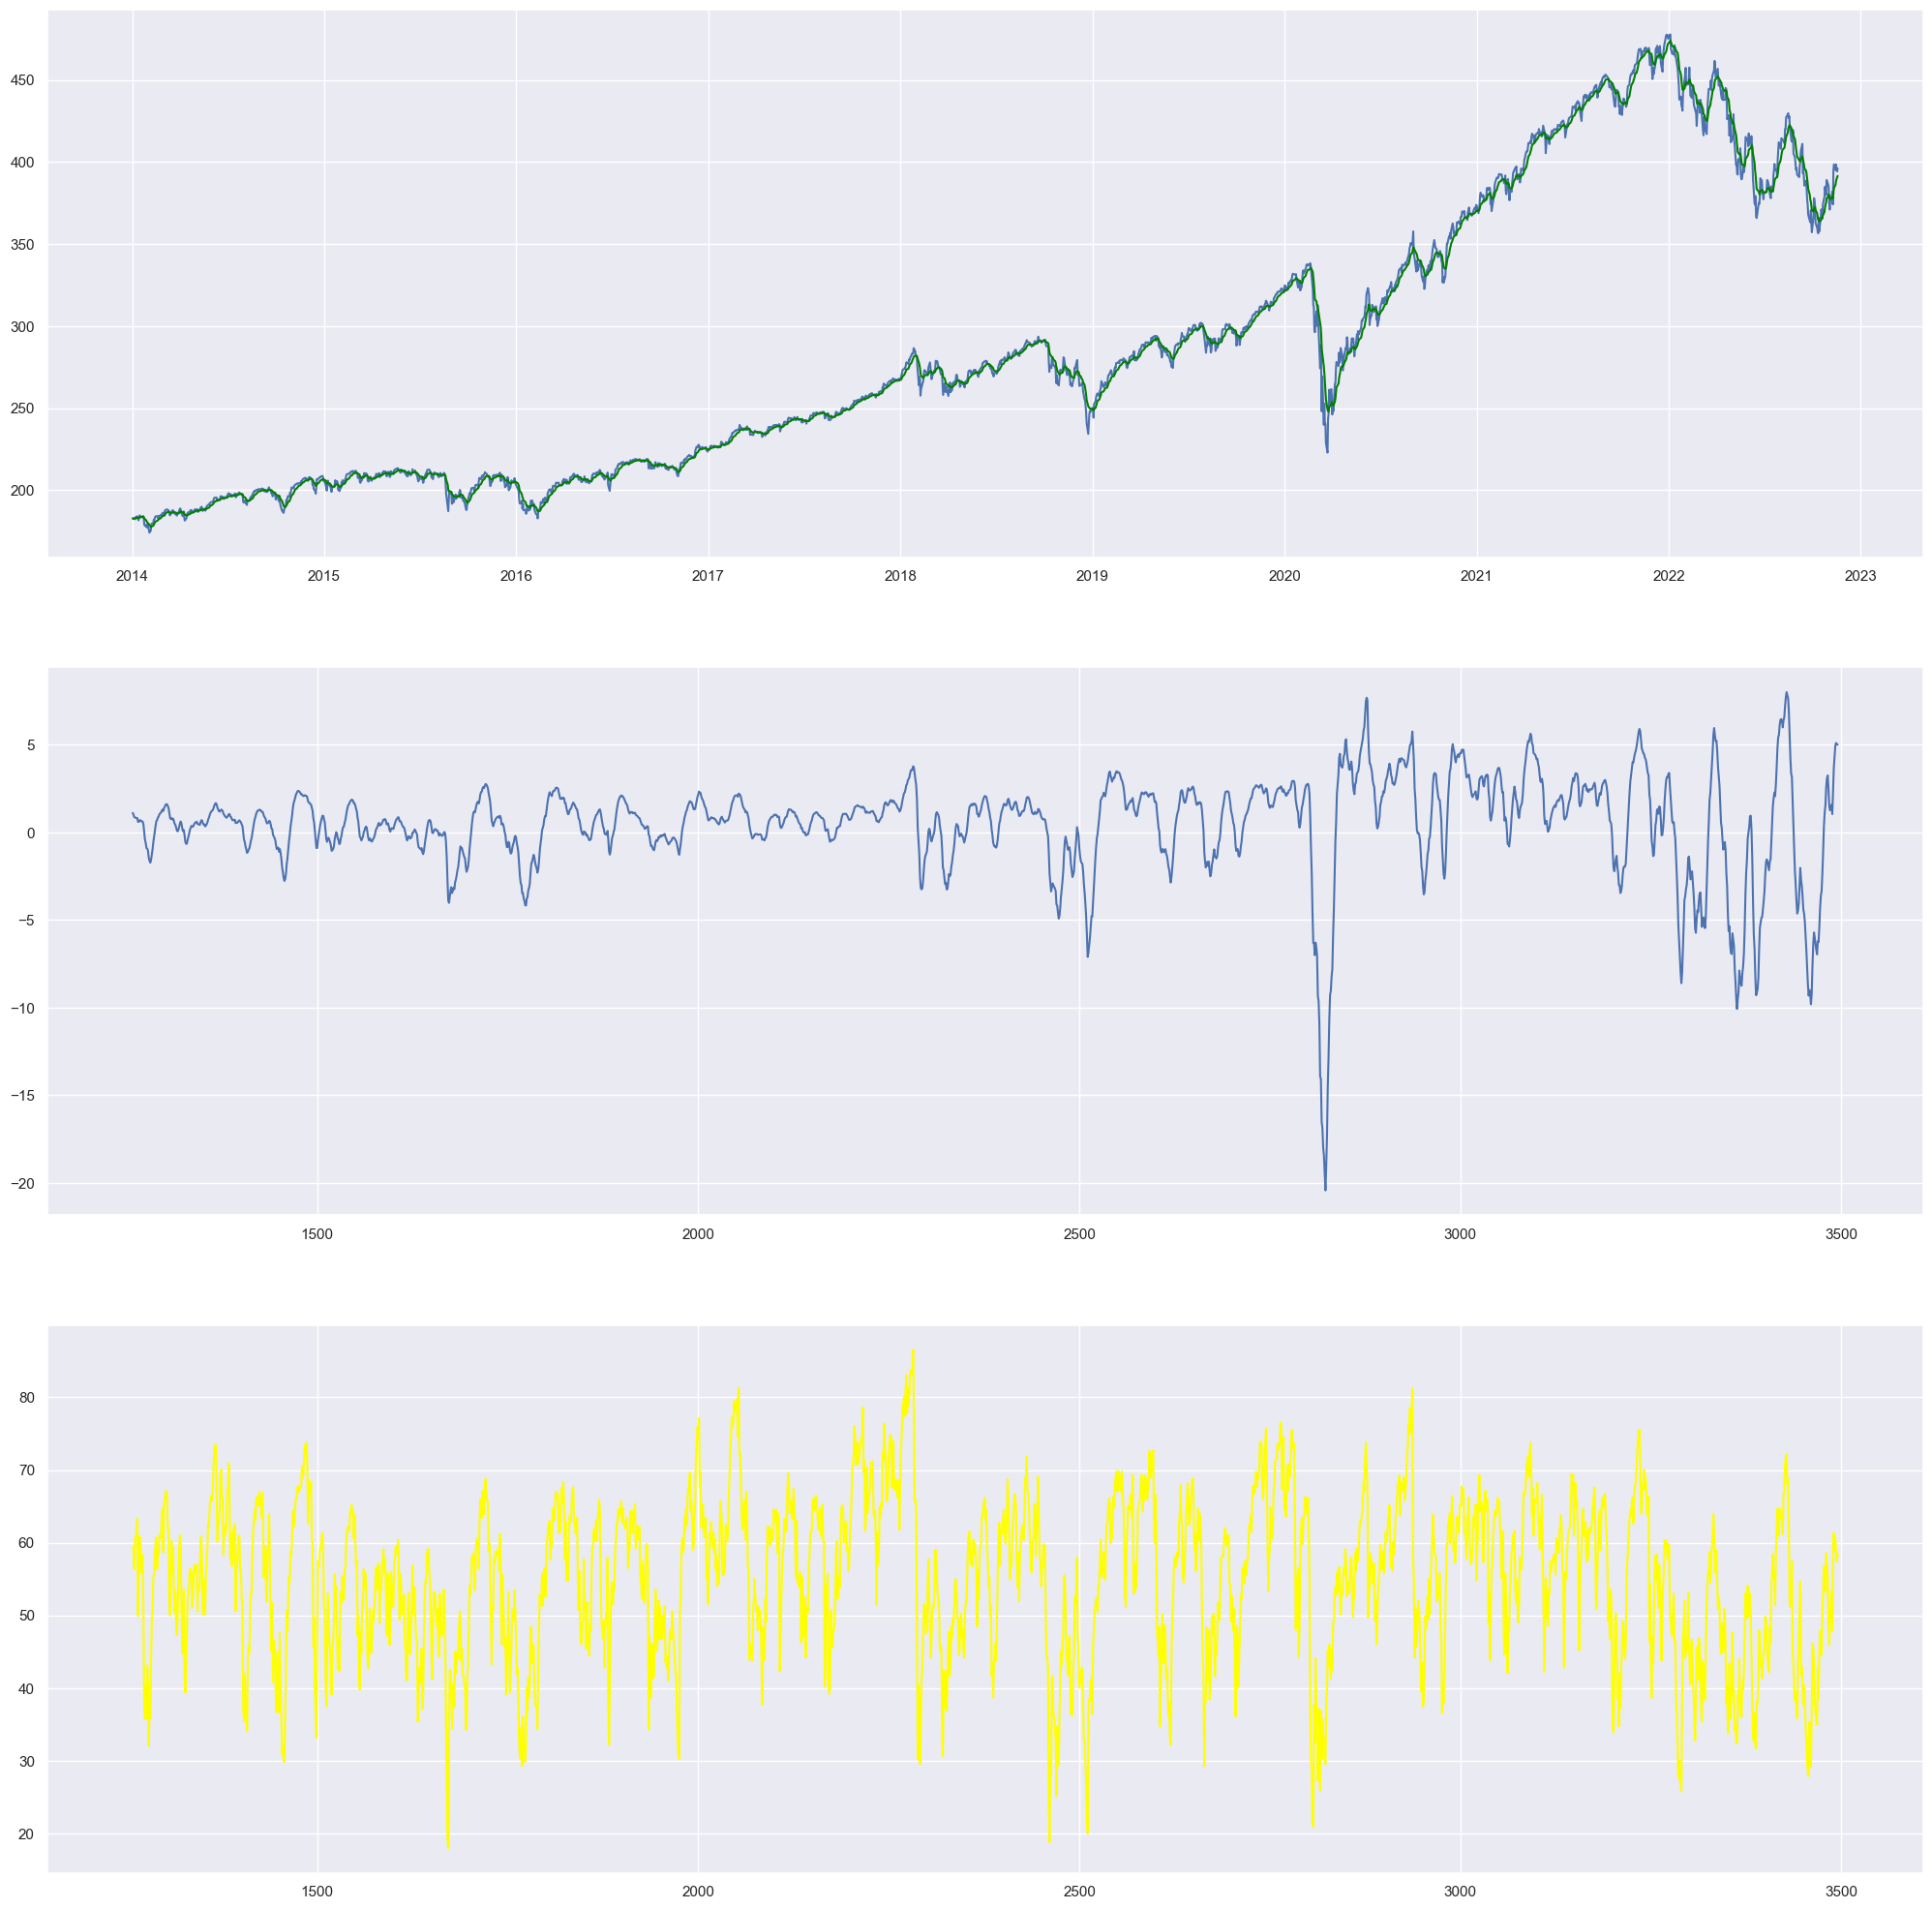

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(25,25) )
axes[0].plot(data['Date'],data['Price'],label='Close Price')
axes[0].plot(data['Date'],data['EMA1'],color='Green' , label='EMA')
axes[1].plot(data['MACD'],label='MACD')
axes[2].plot(data['RSI'],label='RSI',color='yellow')
plt.show()

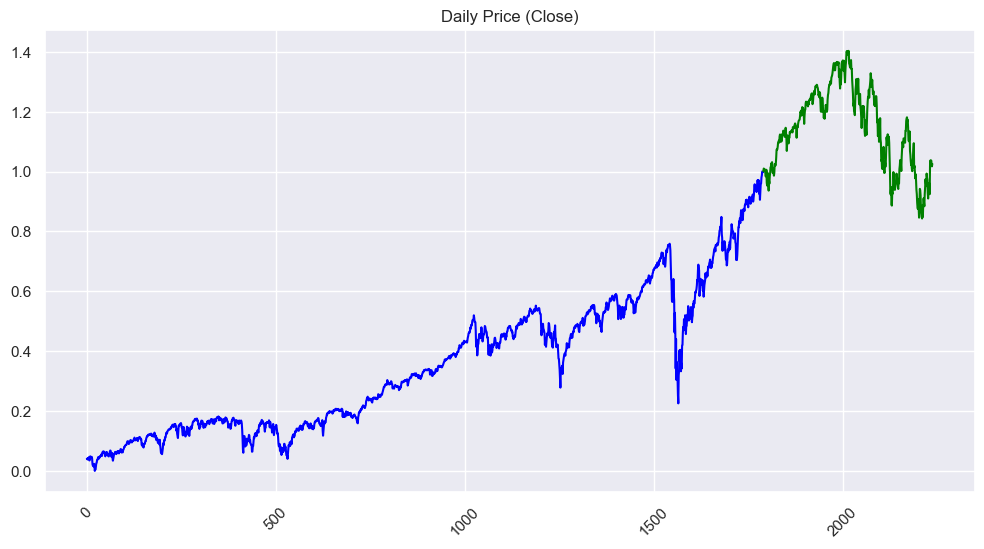

In [18]:
train_df[predict_value].plot(figsize=(12,6),color='blue')
test_df[predict_value].plot(figsize=(12,6), rot=45, color='green')

plt.title('Daily Price (Close)')
plt.show()

### Train the LSTM model

In [22]:
sequence_length = 66
batch_size =32
n_epochs = 60
n_epochs_stop = 6
label_name = predict_value

In [23]:
hist = train.train_model(train_df, test_df, label_name, sequence_length, batch_size, n_epochs, n_epochs_stop)

Starting with model training...
Total number of feature is 4 with learning rate 0.001
Epoch 1 train loss: 0.0127 test loss: 0.0316
Epoch 2 train loss: 0.0739 test loss: 0.0184
Epoch 3 train loss: 0.072 test loss: 0.0963
Epoch 4 train loss: 0.0476 test loss: 0.0187
Epoch 5 train loss: 0.0228 test loss: 0.0105
Epoch 6 train loss: 0.007 test loss: 0.0081
Epoch 7 train loss: 0.0024 test loss: 0.0041
Epoch 8 train loss: 0.0016 test loss: 0.0063
Epoch 9 train loss: 0.0023 test loss: 0.0041
Epoch 10 train loss: 0.0015 test loss: 0.0047
Epoch 11 train loss: 0.0014 test loss: 0.0057
Epoch 12 train loss: 0.0015 test loss: 0.0053
Early stopping.
Completed.


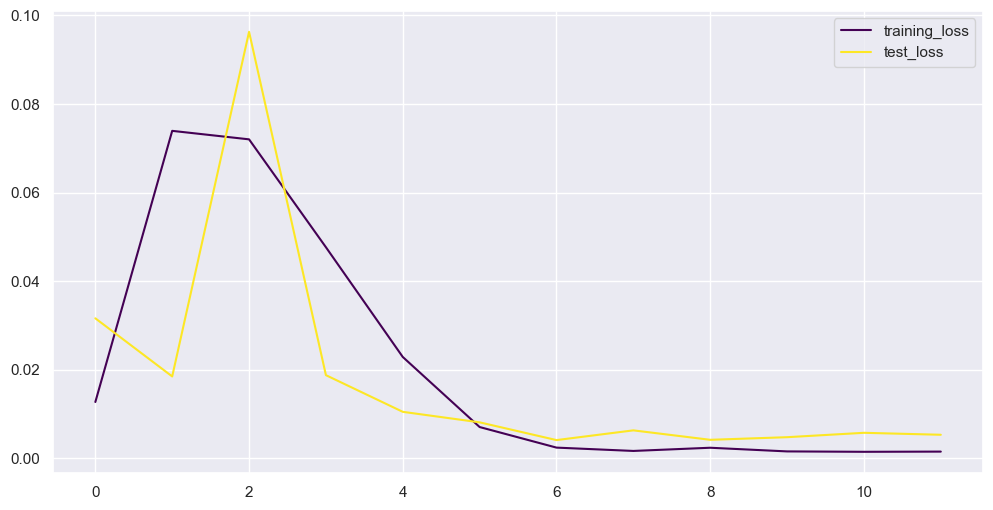

In [24]:
hist.plot(figsize=(12,6), cmap='viridis')
plt.show()

### Evaluate the model

In [25]:
predictions_descaled, labels_descaled = \
    inference.predict(df=test_df,label_name=predict_value,
                                                          sequence_length=sequence_length)

predictions_descaled.shape, predictions_descaled.shape

((382,), (382,))

In [26]:
print('Error on all test data:')
inference.print_loss_metrics(labels_descaled, predictions_descaled)
print('\n')
print('Error on partial test data:')
inference.print_loss_metrics(labels_descaled[:30], predictions_descaled[:30])

Error on all test data:
RMSE:  13.7
MAE:  10.72


Error on partial test data:
RMSE:  3.88
MAE:  2.82


In [27]:
# plot predictions vs true values
df_pred = pd.DataFrame()
df_pred['predicted'] = predictions_descaled
df_pred['true'] = labels_descaled
df_pred['residual'] = labels_descaled - predictions_descaled


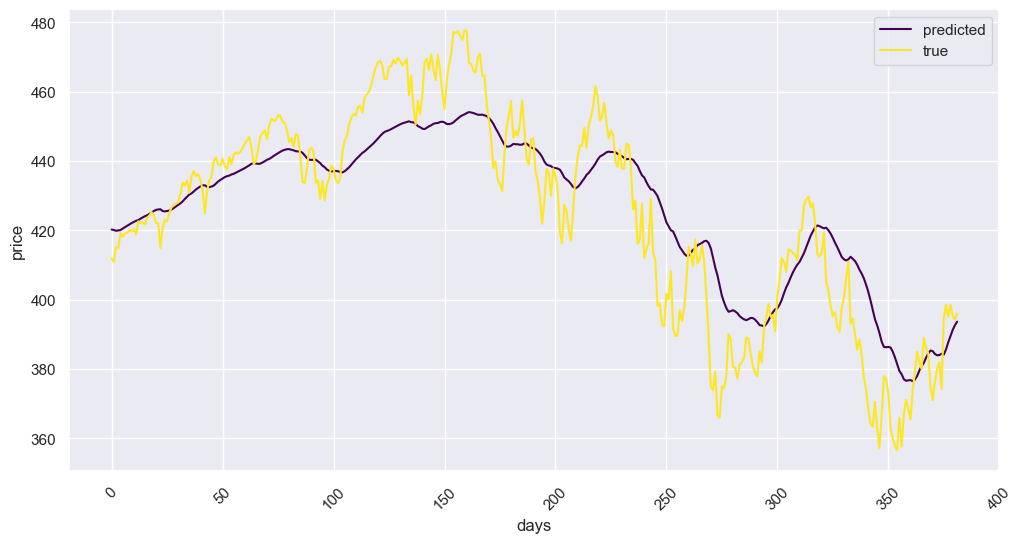

In [28]:
df_pred[['predicted','true']].plot(figsize=(12,6), cmap='viridis')
plt.xticks(rotation=45)
#plt.xlim(0,300)
plt.xlabel('days')
plt.ylabel('price')
plt.legend()
plt.show()

count    382.000000
mean      -1.310193
std       13.652553
min      -40.385961
25%       -9.210762
50%        0.079068
75%        8.140263
max       26.133439
Name: residual, dtype: float64

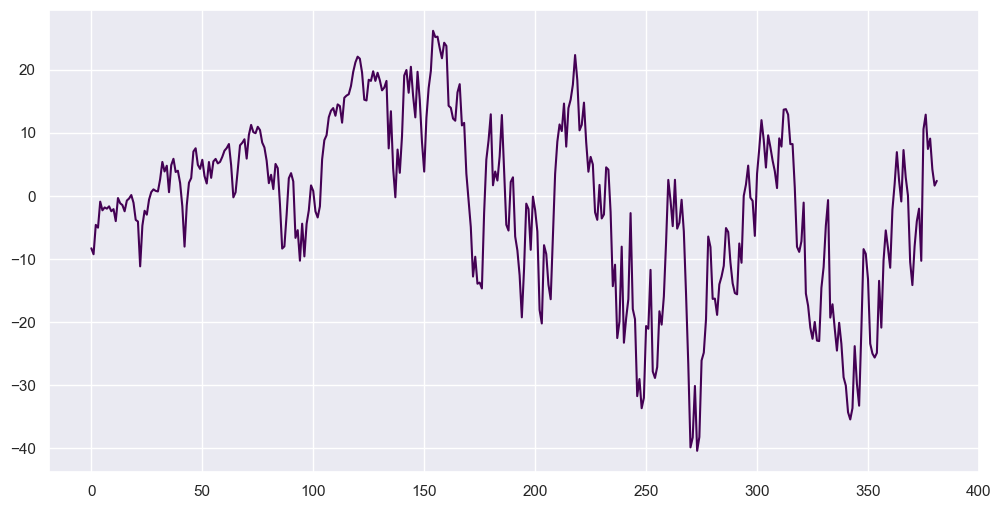

In [29]:
df_pred['residual'].plot(figsize=(12,6), cmap='viridis',label='Acutal-True=Residueal')
df_pred['residual'].describe()

### Find important features

In [30]:
from scripts.train import TimeSeriesDataset, TSModel
from torch.utils.data import DataLoader
import torch
import shap

In [31]:
shap_values = interpret.get_important_features(
    train_df,
    test_df,
    sequence_length
)

Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [32]:
shap_plot = pd.DataFrame(shap_values, columns=train_df.columns.tolist())
shap_plot['days'] = [i-(sequence_length+1) for i in list(range(1,(sequence_length+1)))]
shap_plot.head()

,Price,EMA1,MACD,RSI,days
0,4.617702e-12,3.938234e-12,4.365160e-13,5.894421e-13,-66
1,6.301788e-12,5.192467e-12,6.136110e-13,8.865890e-13,-65
2,8.041410e-12,6.289079e-12,8.040918e-13,1.251862e-12,-64
3,9.743289e-12,7.021235e-12,9.653900e-13,1.704220e-12,-63
4,1.114549e-11,7.055996e-12,1.066712e-12,2.266651e-12,-62


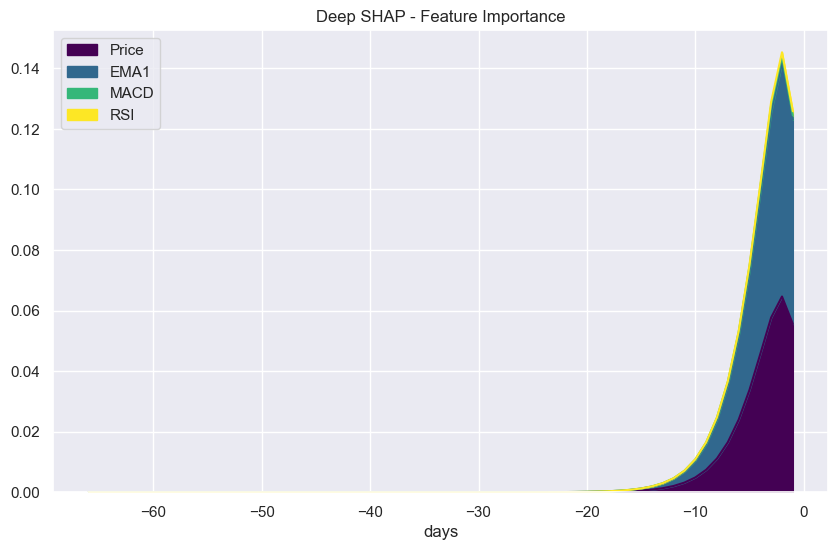

In [33]:
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()